# Using CNN for dogs vs cats

We are going to create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) competition at Kaggle.

There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if you can beat 80%, then you will be at the cutting edge as of 2013!

##  Imports

In [1]:
from PIL import Image
import numpy as np
import pylab as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms,datasets
import torch
import bcolz
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import imp
import utils; imp.reload(utils)
import utils 

In [3]:
torch.__version__

'0.2.0_4'

Check if GPU is available and if so use it by default, otherwise use CPU only.

In [4]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: False 


## Data processing

You can download the full dataset from Kaggle directly.

Alternatively, Jeremy Howard provides a direct link to the catvsdogs [dataset](http://files.fast.ai/data/dogscats.zip). He's separated the cats and dogs into separate folders and created a validation folder as well. You'll need this folder structure to run VGG.

For test purpose (or if you run on cpu), you should use the (small) sample directory available on the [GitHub repo](https://github.com/abursuc/dldiy-practicals)

The ```torchvision``` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the ```torchvision.transforms.Compose``` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

In [5]:
utils.prep1.transforms

In [6]:
#data_dir = '/home/lelarge/courses/data/dogsandcats/sample'
#data_dir = '/home/ubuntu/data/dogscats/sample'
#data_dir = '/home/ubuntu/data/dogscats'
data_dir = 'sample'

In [7]:
!tree -d  $data_dir

sample
├── train
│   ├── cats
│   └── dogs
├── valid
│   ├── cats
│   └── dogs
└── vgg16
    ├── conv_feat_train.bc
    │   ├── data
    │   └── meta
    ├── conv_feat_val.bc
    │   ├── data
    │   └── meta
    ├── labels_train.bc
    │   ├── data
    │   └── meta
    └── labels_val.bc
        ├── data
        └── meta

19 directories


```datasets``` is a class of the ```torchvision``` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network. 

In [8]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), utils.prep1)
         for x in ['train', 'valid']}

In [9]:
dset_classes = dsets['train'].classes
dsets['train'].classes

['cats', 'dogs']

In [10]:
dsets['train'].class_to_idx

{'cats': 0, 'dogs': 1}

In [11]:
dsets['train'].imgs[:5]

[('sample/train/cats/cat.10171.jpg', 0),
 ('sample/train/cats/cat.10539.jpg', 0),
 ('sample/train/cats/cat.10740.jpg', 0),
 ('sample/train/cats/cat.10903.jpg', 0),
 ('sample/train/cats/cat.11269.jpg', 0)]

In [12]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_sizes

{'train': 160, 'valid': 40}

In [13]:
BATCH_SIZE = 2
NUM_WORKERS = 1

In [14]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=BATCH_SIZE,
                                               shuffle={'train':1,'valid':0}, num_workers=NUM_WORKERS)
                for x in ['train', 'valid']}

In [15]:
dataset_valid = torch.utils.data.DataLoader(dsets['valid'], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [16]:
inputs_try,labels_try = iter(dataset_valid).next()
assert(len(labels_try)==BATCH_SIZE)
assert(inputs_try.shape[0]==BATCH_SIZE)
print labels_try
print inputs_try.shape


 0
 1
[torch.LongTensor of size 2]

torch.Size([2, 3, 224, 224])


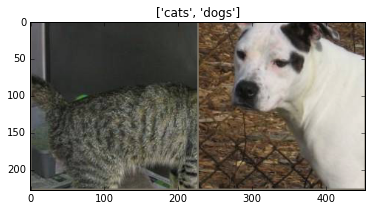

In [17]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)
utils.imshow(out)
plt.title([dset_classes[x] for x in labels_try])

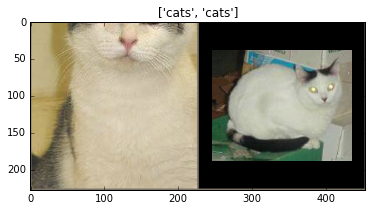

In [18]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

utils.imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

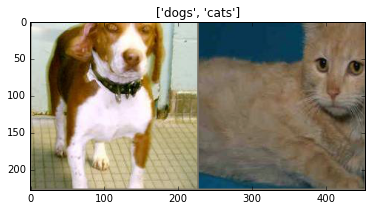

In [19]:
# Get a batch of validation data
inputs, classes = next(iter(dset_loaders['valid']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

utils.imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## Creating VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if ```pretrained=True``` the model is fetched over the internet and downloaded to ```~/.torch/models```.
For next calls, the model will be directly read from there.

In [20]:
model_vgg = models.vgg16(pretrained=True)

We will first use VGG Model without any modification. In order to interpret the results, we need to import the 1000 ImageNet categories, available at: 
https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [21]:
import json
fpath = 'data/imagenet_class_index.json'
with open(fpath) as f:
    class_dict = json.load(f)
dic_imagenet = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [22]:
dic_imagenet[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

In [23]:
inputs_try , labels_try = utils.var_cgpu(inputs_try,use_gpu), utils.var_cgpu(labels_try,use_gpu)
if use_gpu:
    model_vgg = model_vgg.cuda()

In [24]:
outputs_try = model_vgg(inputs_try)

In [25]:
outputs_try

Variable containing:
 -2.4780  -0.8969  -2.4913  ...   -1.8366   1.4782   1.4035
 -0.9806  -4.9499   3.1838  ...    0.3460  -1.9060   4.7389
[torch.FloatTensor of size 2x1000]

For a better interpretation, we transform this output in probablities thanks to the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) and then take the max.

In [26]:
# torch.max?

In [27]:
m_softm = nn.Softmax()
# torch.max(..,axis=1) -> max and argmax along axis 1
vals_try,preds_try = torch.max(m_softm(outputs_try.data),1)

In [28]:
vals_try,preds_try

(Variable containing:
  0.4161
  0.4101
 [torch.FloatTensor of size 2], Variable containing:
  285
  180
 [torch.LongTensor of size 2])

In [31]:
print([dic_imagenet[i] for i in preds_try.data])

[u'Egyptian_cat', u'American_Staffordshire_terrier']


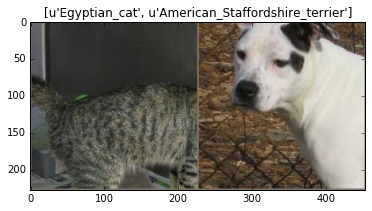

In [32]:
#corresponding images
out = torchvision.utils.make_grid(inputs_try.data.cpu())

utils.imshow(out, title=[dic_imagenet[i] for i in preds_try.data])

### Modifying the last layer and setting the gradient false to all layers

In [33]:
print(model_vgg)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

An illustration taken from [Deep Learning with PaddlePaddle](http://book.paddlepaddle.org/)

<img src='data/vgg16.png'>

In this practical example, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last ```nn.Linear``` layer trained for 1000 classes to ones with 2 classes. In order to freeze the weights of the other layers during training, we set the field ```required_grad=False```. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 2 class layer will be updated.

In [34]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2) # size is the last layer (see above)
#model_vgg.classifier[6].out_features = 2
#for param in model_vgg.classifier[6].parameters():
#    param.requires_grad = True

In [35]:
print(model_vgg.classifier)

Sequential (
  (0): Linear (25088 -> 4096)
  (1): ReLU (inplace)
  (2): Dropout (p = 0.5)
  (3): Linear (4096 -> 4096)
  (4): ReLU (inplace)
  (5): Dropout (p = 0.5)
  (6): Linear (4096 -> 2)
)


In [36]:
if use_gpu:
    model_vgg = model_vgg.cuda()

### Calculating preconvoluted features

In [38]:
x_try = model_vgg.features(inputs_try)

In [43]:
x_try.data.shape

torch.Size([2, 512, 7, 7])

In [44]:
labels_try

Variable containing:
 0
 1
[torch.LongTensor of size 2]

In [55]:
try:
    from tqdm import tqdm_notebook as tqdm
except ImportError:
    print("You can install the progress bar widget tqdm with:")
    print("conda install tqdm")
    print("Continuing anyway")
    tqdm = lambda x:x
    
def preconvfeat(dataset):
    conv_features = [] # 
    labels_list = []   # this approach can be memory hungry -- consider dumping to disk if needed
    for data in tqdm(dataset):
        inputs,labels = data
        if use_gpu:
            inputs , labels = Variable(inputs.cuda()),Variable(labels.cuda())
        else:
            inputs , labels = Variable(inputs),Variable(labels)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [56]:
%%time
conv_feat_train,labels_train = preconvfeat(dset_loaders['train'])

HBox(children=(IntProgress(value=0, max=80), HTML(value=u'')))


CPU times: user 3min 50s, sys: 21.1 s, total: 4min 11s
Wall time: 2min 6s


In [57]:
%%time
conv_feat_val,labels_val = preconvfeat(dset_loaders['valid'])

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))


CPU times: user 59.3 s, sys: 2.88 s, total: 1min 2s
Wall time: 31.3 s


In [58]:
%mkdir -p $data_dir/vgg16/

In [59]:
utils.save_array(data_dir+'/vgg16/conv_feat_train.bc',conv_feat_train)
utils.save_array(data_dir+'/vgg16/labels_train.bc',labels_train)
utils.save_array(data_dir+'/vgg16/conv_feat_val.bc',conv_feat_val)
utils.save_array(data_dir+'/vgg16/labels_val.bc',labels_val)

### Loading Preconvoluted features

In [60]:
conv_feat_train = utils.load_array(data_dir+'/vgg16/conv_feat_train.bc')
labels_train = utils.load_array(data_dir+'/vgg16/labels_train.bc')
conv_feat_val = utils.load_array(data_dir+'/vgg16/conv_feat_val.bc')
labels_val = utils.load_array(data_dir+'/vgg16/labels_val.bc')

In [61]:
conv_feat_train.shape

(160, 512, 7, 7)

## Training fully connected module

### Creating loss function and optimizer

In [74]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
# SGD: stochastic gradient descend
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr,momentum=.01,nesterov=1)

In [75]:
# criterion?
optimizer_vgg.step?

### Creating Data generator

In [76]:
def data_gen(conv_feat,labels,batch_size=BATCH_SIZE,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

### Training the model

In [77]:
def train_model(model,size,conv_feat=None,labels=None,epochs=1,optimizer=None,train=True,shuffle=True):
    if train:
        model.train()
    else:
        model.eval()
        
    for epoch in range(epochs):
        batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            
            # cast to pytorch types
            if use_gpu:
                inputs , classes = Variable(torch.from_numpy(inputs).cuda()),Variable(torch.from_numpy(classes).cuda())
            else:
                inputs , classes = Variable(torch.from_numpy(inputs)),Variable(torch.from_numpy(classes))
                
            inputs = inputs.view(inputs.size(0), -1) # flatten?
            outputs = model(inputs)                  # compute the function (aka attempt classification) 
            loss = criterion(outputs,classes)        # compute loss (when fitting with chi2 it's sum rms)
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
#                 optimizer = optimizer #????? <- this seems useless! It's NOT a copy
                optimizer.zero_grad()                # reset gradient... why?
                loss.backward()                      # backward propagations is done on loss?? not on optimizer?
                optimizer.step()                     # optimization step (as per pytorch doc)
            
            _,preds = torch.max(outputs.data,1)      # super cryptic way to get predicted classes
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    

In [78]:
%%time
train_model(model=model_vgg.classifier,size=dset_sizes['train'],conv_feat=conv_feat_train,labels=labels_train,
            epochs=10,optimizer=optimizer_vgg,train=True,shuffle=True)

Loss: 0.0876 Acc: 0.0000
Loss: 0.2558 Acc: 0.0000
Loss: 0.0086 Acc: 0.0000
Loss: 0.0371 Acc: 0.0000
Loss: 0.0000 Acc: 1.0000
Loss: 0.0563 Acc: 0.0000
Loss: 0.0000 Acc: 1.0000
Loss: 0.0852 Acc: 0.0000
Loss: 0.0000 Acc: 1.0000
Loss: 0.0014 Acc: 1.0000
CPU times: user 4min 44s, sys: 4.68 s, total: 4min 48s
Wall time: 1min 39s


In [79]:
train_model(conv_feat=conv_feat_val,labels=labels_val,model=model_vgg.classifier
            ,size=dset_sizes['valid'],train=False,shuffle=False)

Loss: 0.0001 Acc: 1.0000


In [80]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['valid']))

In [83]:
model_vgg(inputs.view(inputs.shape[0],-1))

ValueError: Expected 4D tensor as input, got 2D tensor instead.

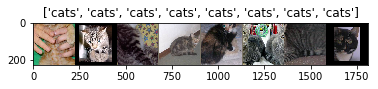

In [52]:
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [55]:
inputs = Variable(torch.from_numpy(conv_feat_val[:n_images]))
inputs = inputs.view(inputs.size(0), -1)
if use_gpu:
    outputs = model_vgg.classifier(inputs.cuda())
else:
    outputs = model_vgg.classifier(inputs)
print(m_softm(outputs))

Variable containing:
 9.7413e-01  2.5871e-02
 1.0000e+00  4.4412e-09
 9.9954e-01  4.5642e-04
 1.0000e+00  1.0324e-06
 9.9969e-01  3.1015e-04
 1.0000e+00  3.8068e-06
 9.9988e-01  1.1613e-04
 1.0000e+00  5.4490e-07
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]



In [56]:
labels_val[:n_images]

array([0, 0, 0, 0, 0, 0, 0, 0])

## Creating VGG model by hand

In [57]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class VGG_16(nn.Module):

    def __init__(self,num_classes=1000):
        super(VGG_16, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )       

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def init_weight(self,w):
        i=0
        for idx, m in enumerate(self.children()):
            for idy, msub in enumerate(m.children()):
                classname = msub.__class__.__name__
                if classname.find('Conv') != -1:
                    msub.weight.data = w['features.'+str(i)+'.weight']#.clone()
                    msub.bias.data = w['features.'+str(i)+'.bias']#.clone()
                    print(msub,'features.'+str(i))
                if classname.find('Linear') != -1:
                    msub.weight.data = w['classifier.'+str(i-31)+'.weight']#.clone()
                    msub.bias.data = w['classifier.'+str(i-31)+'.bias']#.clone()
                    print(msub,'classifier.'+str(i-31))
                i +=1
        

net = VGG_16()
print(net)

VGG_16 (
  (convblock1): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (convblock2): Sequential (
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (convblock3): Sequential (
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU (inplace)
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))


### Filling our model with learned weights

Now that we created VGG model, we do not want to train it from scratch. Fortunately, this has been done for us and we only need to get the weights and fill them properly which is the purpose of the init_weight method defined above.

In [58]:
import torch.utils.model_zoo as model_zoo
weights = model_zoo.load_url('https://download.pytorch.org/models/vgg16-397923af.pth')

In [59]:
type(weights)

collections.OrderedDict

In [60]:
net.init_weight(weights)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.0
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.2
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.5
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.7
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.10
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.12
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.14
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.17
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.19
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.21
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.24
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) features.26
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

To understand what the init_weight method is doing:

In [61]:
weights.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [62]:
inc=0
for idx, m in enumerate(net.children()):
    for idy, msub in enumerate(m.children()):
        print(inc, '->', msub)
        inc +=1

0 -> Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 -> ReLU (inplace)
2 -> Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 -> ReLU (inplace)
4 -> MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
5 -> Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 -> ReLU (inplace)
7 -> Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 -> ReLU (inplace)
9 -> MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
10 -> Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 -> ReLU (inplace)
12 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 -> ReLU (inplace)
14 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 -> ReLU (inplace)
16 -> MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
17 -> Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 -> ReLU (inplace)
19 -> Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

Now our model is ready for use, let's try it!

In [63]:
for param in net.parameters():
    param.requires_grad = False
net.classifier._modules['6'] = nn.Linear(4096, 2)

In [64]:
net

VGG_16 (
  (convblock1): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (convblock2): Sequential (
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (convblock3): Sequential (
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU (inplace)
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))


In [65]:
if use_gpu:
    net = net.cuda()

In [66]:
optimizer_net = torch.optim.SGD(net.classifier[6].parameters(),lr = lr)

In [67]:
%%time
(train_model(model=net.classifier,size=dset_sizes['train'],conv_feat=conv_feat_train,labels=labels_train,
            epochs=10,optimizer=optimizer_net,train=True,shuffle=True))

Loss: 0.0012 Acc: 0.9707
Loss: 0.0009 Acc: 0.9774
Loss: 0.0009 Acc: 0.9781
Loss: 0.0008 Acc: 0.9790
Loss: 0.0008 Acc: 0.9805
Loss: 0.0008 Acc: 0.9794
Loss: 0.0008 Acc: 0.9807
Loss: 0.0008 Acc: 0.9800
Loss: 0.0007 Acc: 0.9809
Loss: 0.0008 Acc: 0.9812
CPU times: user 43.8 s, sys: 11.6 s, total: 55.4 s
Wall time: 55.3 s


Let's see what it gives on our 'try' sample (5 random images from the validation set).

In [76]:
new_outputs_try = net(inputs_try)

In [80]:
new_outputs_try.data


-2.3383  1.3432
 2.2118 -2.9348
-3.3123  2.8153
 1.0792 -1.1584
-1.5835  1.4730
[torch.FloatTensor of size 5x2]

In [88]:
new_vals_try,new_preds_try = torch.max(m_softm(new_outputs_try.data),1)

In [89]:
new_preds_try

Variable containing:
 1
 0
 1
 0
 1
[torch.LongTensor of size 5]

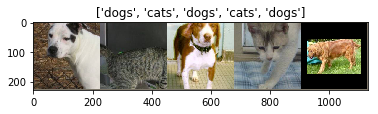

In [90]:
#corresponding images
out = torchvision.utils.make_grid(inputs_try.data.cpu())

imshow(out, title=[dset_classes[x] for x in labels_try.data.cpu()])

In [91]:
new_vals_try

Variable containing:
 0.9754
 0.9942
 0.9978
 0.9036
 0.9551
[torch.FloatTensor of size 5]